In [4]:
%pip install opencv-python matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [109]:
# from hand_transform import *
import torchvision.transforms.v2 as transforms

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2
import torchvision.models as visionmodels

import torch.nn as nn

import lightning as L
import numpy as np
import cv2 as cv

from custom_transforms import RandomNoiseBackgroundTransform

In [110]:
img_size = 224

# See https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
# for more examples of transforms

# Open Idea: Grayscale for anti bias


data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.3), # Idea: ColorJitter for anti bias
    transforms.RandomRotation(degrees=5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

/opt/conda/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [111]:
class BackgroundNoiseTransform(nn.Module):
    def __init__(self, brightness=0.75, contrast=0.3, saturation=.75, hue=0.4):
        super().__init__()
        self.color_jitter = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)

    def get_hand_filter(self, img):
        image_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
       
        hsv_min = [np.array([0, 0, 100])]
        hsv_max = [np.array([180, 60,255])]
        
        hsv_min, hsv_max = np.array(hsv_min), np.array(hsv_max)
           
        background_image_hsv = sum([cv.inRange(image_hsv, lower, upper) for lower, upper in zip(hsv_min, hsv_max)])
        
        binary = np.copy(background_image_hsv)
        binary = cv.bitwise_not(binary)
        
        binary = cv.GaussianBlur(binary, (3,3), 3)
        return binary

    def noise(self, mask, img):
        noise = np.random.uniform(0, 255, size=img.shape).astype(np.uint8)
        noise[mask == 255] = img[mask == 255]
        return noise  
    
    def __call__(self, img):
        color_jittered = np.array(self.color_jitter(img))
        
        img_np = np.array(img)
        mask = self.get_hand_filter(img_np)
        
        noised = self.noise(mask, color_jittered)
        noised_with_gaussian = cv.GaussianBlur(noised, (3,3), 1.5)

        return Image.fromarray(noised_with_gaussian)


In [124]:
t = transforms.Compose(transforms=(
    transforms.Resize(size=(224, 224)),
    RandomNoiseBackgroundTransform(brightness=1.0, contrast=0.0, saturation=1.0, hue=0.5),
    #transforms.ColorJitter(brightness=1.0, contrast=0.0, saturation=1.0, hue=0.5),
    #transforms.Grayscale(),
    #transforms.GaussianBlur(kernel_size=(3,3),sigma=3)
))

In [125]:
# orig_img = Image.open(Path("/home/jovyan/Test-Hands/A") / 'A_1.jpeg')
orig_img = Image.open(Path(r"/exchange/dspro2/silent-speech/ASL_Pictures_Dataset/Train/D") / '10.jpg')

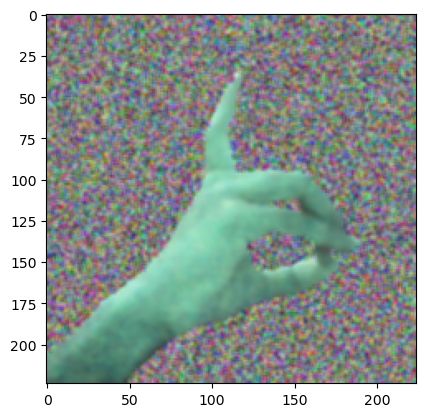

In [135]:
plt.imshow(t(orig_img))